In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Set plot style
sns.set_theme(style="whitegrid")

In [2]:
# Load the datasets
try:
    df_train = pd.read_csv('train(1)(train(1)).csv')
    df_test = pd.read_csv('test2(test(1)).csv')
except FileNotFoundError:
    #Google Drive
    from google.colab import drive
    drive.mount('/content/drive')
    BASE_DIR = '/content/drive/MyDrive/cdc' # Update path if needed
    df_train = pd.read_csv(f'{BASE_DIR}/train(1)(train(1)).csv')
    df_test = pd.read_csv(f'{BASE_DIR}/test2(test(1)).csv')

print(f"Train Shape: {df_train.shape}")
print(f"Test Shape: {df_test.shape}")

Mounted at /content/drive
Train Shape: (16209, 21)
Test Shape: (5404, 20)


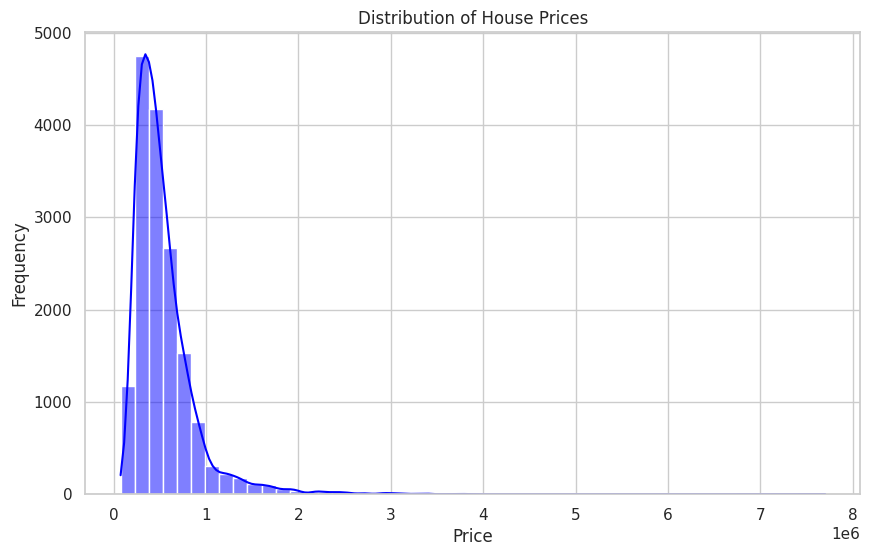

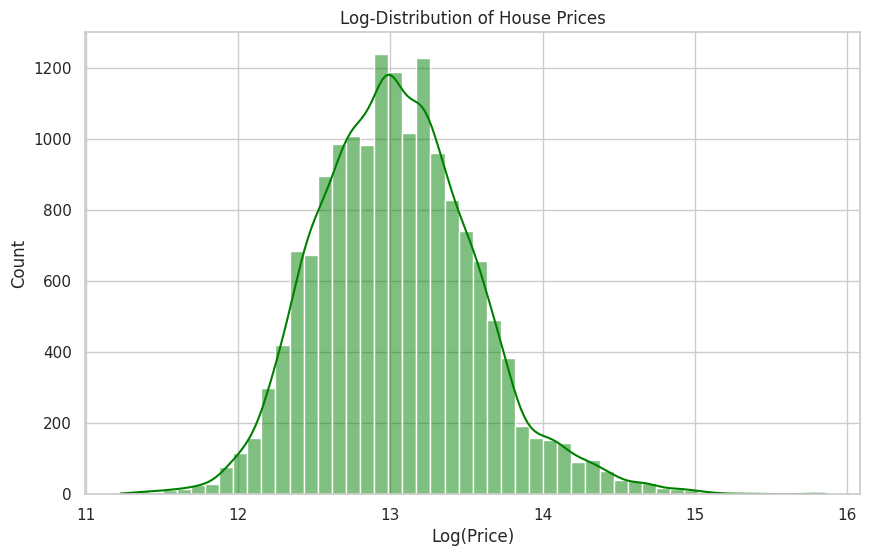

In [3]:
# 1. Price Distribution (Target Variable)
plt.figure(figsize=(10, 6))
sns.histplot(df_train['price'], bins=50, kde=True, color='blue')
plt.title('Distribution of House Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

# Log-transformed Price Distribution (helpful for skewed data)
plt.figure(figsize=(10, 6))
sns.histplot(np.log1p(df_train['price']), bins=50, kde=True, color='green')
plt.title('Log-Distribution of House Prices')
plt.xlabel('Log(Price)')
plt.show()

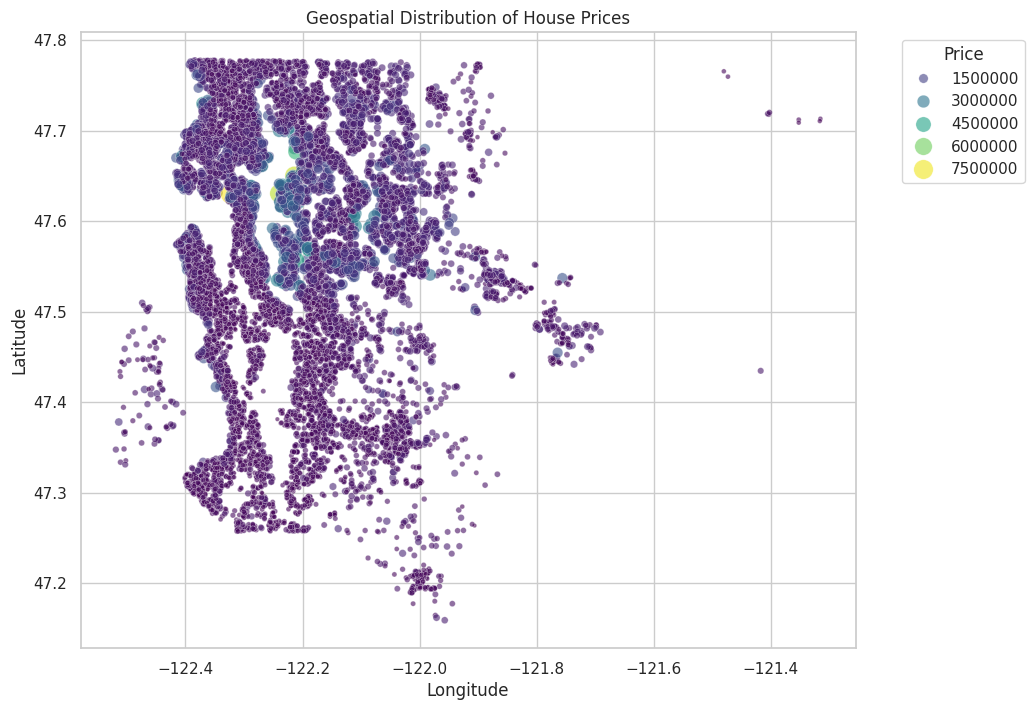

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=df_train,
    x='long',
    y='lat',
    hue='price',
    palette='viridis',
    size='price',
    sizes=(10, 200),
    alpha=0.6
)
plt.title('Geospatial Distribution of House Prices')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Price', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

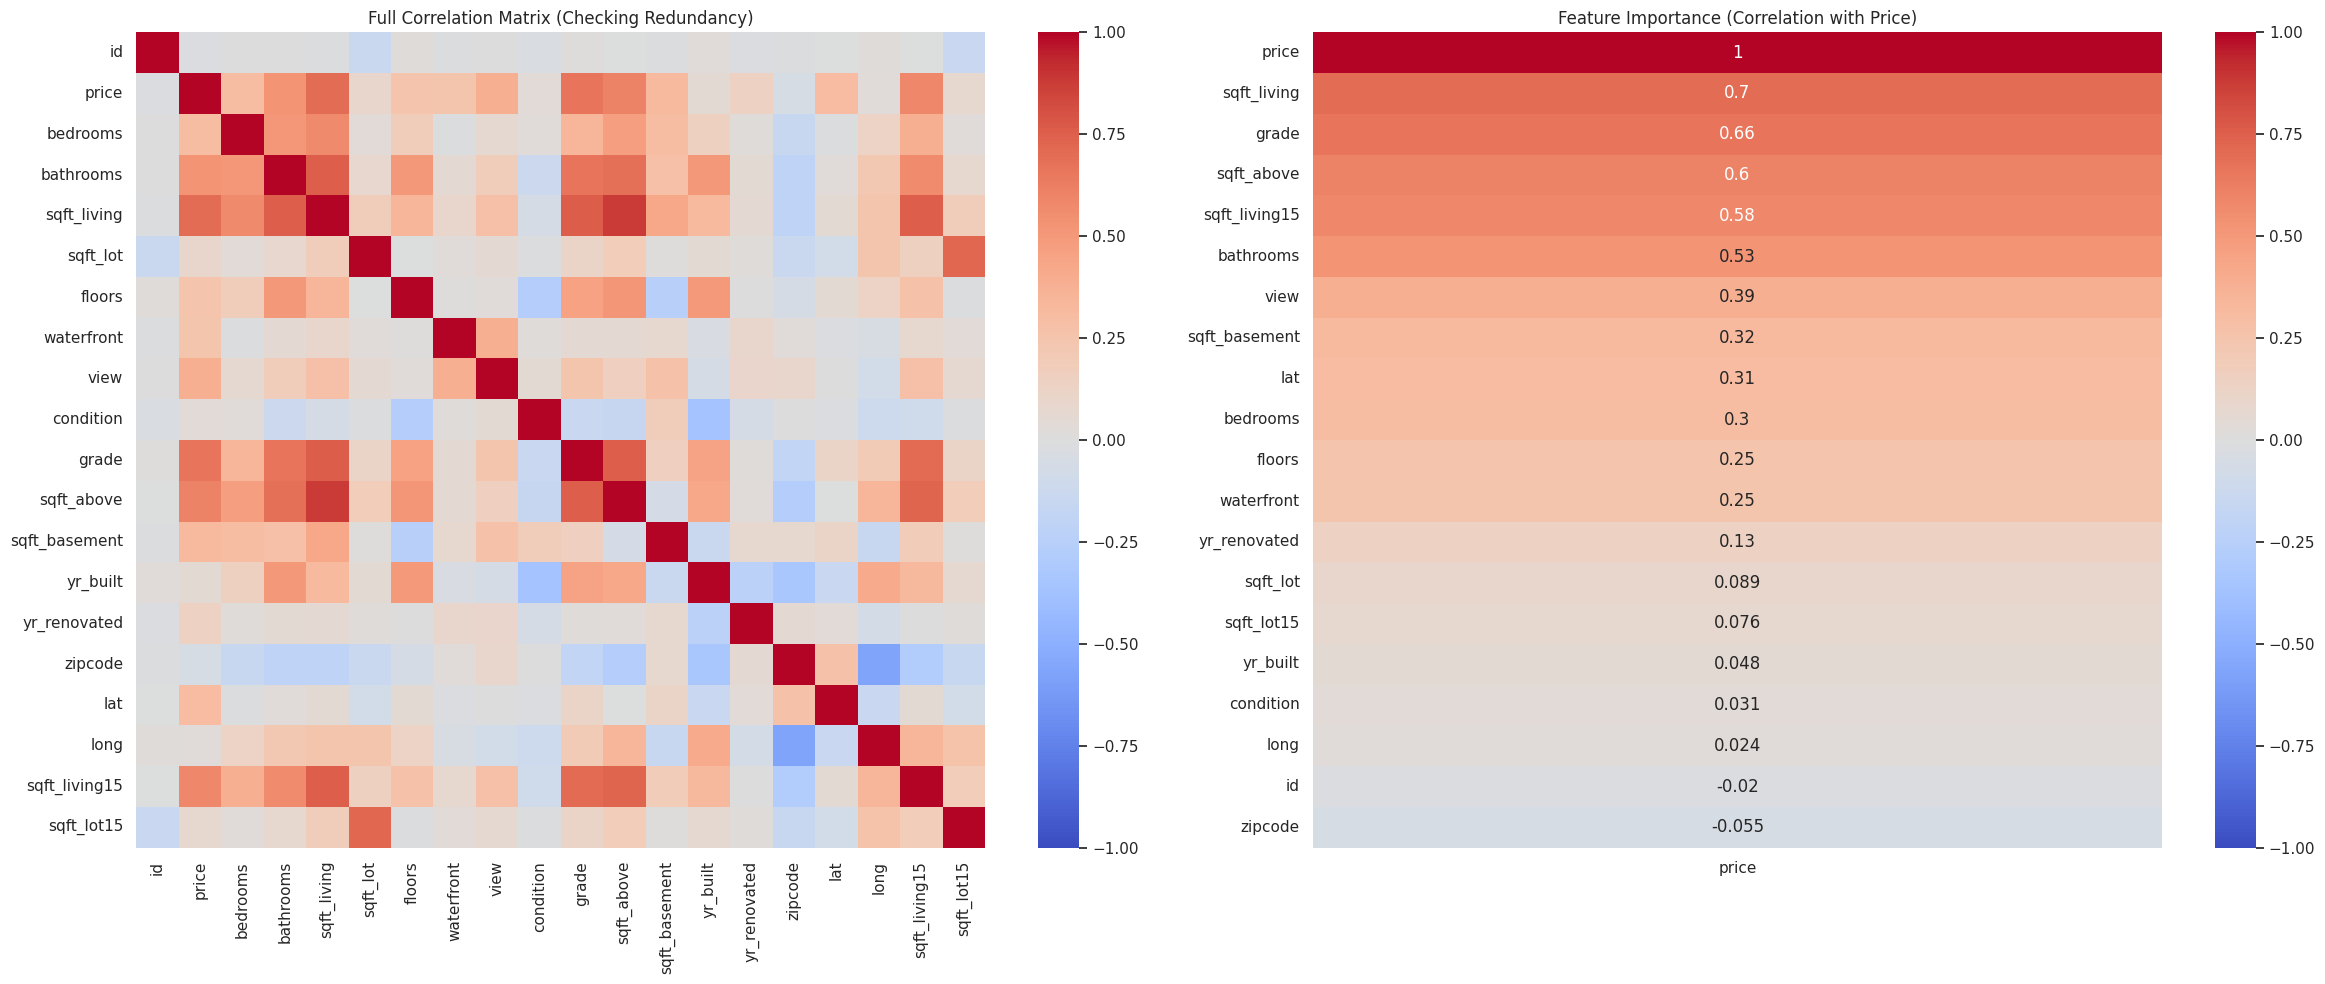

In [4]:
# 2. Correlation Matrix
# Select numeric columns
numeric_df = df_train.select_dtypes(include=[np.number])
corr_matrix = numeric_df.corr()

# Create a figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))

# PLOT 1: Full Matrix
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1, ax=ax1)
ax1.set_title('Full Correlation Matrix (Checking Redundancy)')

# PLOT 2: Target Correlation
# We sort it to make it a ranked list
target_corr = corr_matrix[['price']].sort_values(by='price', ascending=False)
sns.heatmap(target_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, ax=ax2)
ax2.set_title('Feature Importance (Correlation with Price)')

plt.tight_layout()
plt.show()

In [12]:
from sklearn.impute import SimpleImputer

# Preprocessing
# Drop non-predictive columns
low_corr_cols = ['id','price','date']
X = df_train.drop(columns=low_corr_cols)
y = df_train['price']

# Handle missing values (Imputation)
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

# Convert back to DataFrame so we keep column names
X = pd.DataFrame(X_imputed, columns=X.columns)

# Split Data (Same split as the DL pipeline for fair comparison)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=13)

print(f"Training Baseline on {X_train.shape[0]} samples...")


Training Baseline on 12967 samples...


In [15]:
# Train Random Forest
rf_model = RandomForestRegressor(n_estimators=150, random_state=13, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Evaluate
y_pred = rf_model.predict(X_val)

rmse = np.sqrt(mean_squared_error(y_val, y_pred))
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print("Baseline (Tabular Only) Results")
print(f"RMSE: {rmse:,.2f}")
print(f"MAE:  {mae:,.2f}")
print(f"R²:   {r2:.4f}")

Baseline (Tabular Only) Results
RMSE: 119,927.87
MAE:  68,561.88
R²:   0.8741


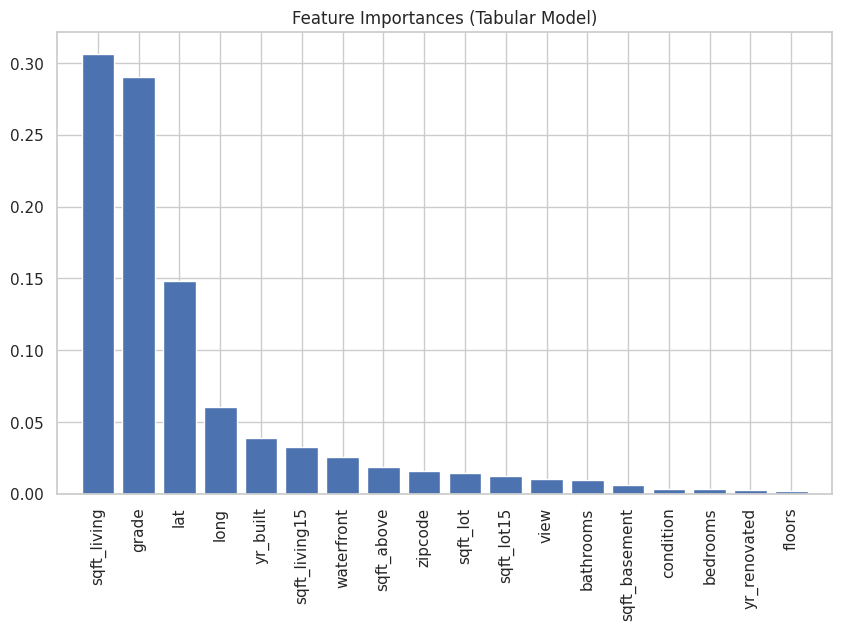

In [16]:
# Feature Importance
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances (Tabular Model)")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()